# Gibbs free energy expressions for IN625 from ternary CALPHAD DB

This notebook extracts relevant thermodynamic functions necessary for the
phase-field model of solid-state transformations in additively manufactured
superalloy 625, represented as a ternary (Cr-Nb-Ni) with γ, δ, μ, and Laves
phases competing. The thermodynamic database was prepared by U. Kattner after
Du, Liu, Chang, and Yang (2005):

```
@Article{Du2005,
    Title   = {A thermodynamic modeling of the Cr–Nb–Ni system },
    Author  = {Yong Du and Shuhong Liu and Y.A. Chang and Ying Yang},
    Journal = {Calphad},
    Year    = {2005},
    Volume  = {29},
    Number  = {2},
    Pages   = {140 - 148},
    Doi     = {10.1016/j.calphad.2005.06.001}
}
```

This database models the phases of interest as follows:
- γ as $\mathrm{(Cr, Nb, Ni)}$
- δ as $\mathrm{(\mathbf{Nb}, Ni)_1(Cr, Nb, \mathbf{Ni})_3}$
- μ as $\mathrm{Nb_6(Cr, Nb, Ni)_7}$
- Laves as $\mathrm{(\mathbf{Cr}, Nb, Ni)_2(Cr, \mathbf{Nb})_1}$

The phase field model requires Gibbs free energies as functions of system
compositions $x_\mathrm{Cr}$, $x_\mathrm{Nb}$, $x_\mathrm{Ni}$. The Calphad
database represents these energies as functions of sublattice compositions
$y$ in each phase. To avoid solving for internal phase equilibrium at each
point in the simulation, approximations have been made to allow the following
one-to-one mappings between $x$ and $y$:

- γ: no changes necessary
     * $y_\mathrm{Cr}' = x_\mathrm{Cr}$
     * $y_\mathrm{Nb}' = x_\mathrm{Nb}$
     * $y_\mathrm{Ni}' = x_\mathrm{Ni}$
- δ: eliminate Nb from the second (Ni) sublattice, $\mathrm{(\mathbf{Nb}, Ni)_1(Cr, \mathbf{Ni})_3}$
     * $y_\mathrm{Nb}'  = 4x_\mathrm{Nb}$
     * $y_\mathrm{Ni}'  = 1-4x_\mathrm{Nb}$
     * $y_\mathrm{Cr}'' = \frac{4}{3}x_\mathrm{Cr}$
     * $y_\mathrm{Ni}'' = 1-\frac{4}{3}x_\mathrm{Cr}$
     * Constraints: 
         * $x_\mathrm{Nb}\leq\frac{1}{4}$
         * $x_\mathrm{Cr}\leq\frac{3}{4}$
- μ: no changes necessary
     * $y_\mathrm{Nb}'  = 1$
     * $y_\mathrm{Cr}'' = x_\mathrm{Cr}$
     * $y_\mathrm{Nb}'' = \frac{13}{7}x_\mathrm{Nb}-\frac{6}{7}$
     * $y_\mathrm{Ni}'' = x_\mathrm{Ni}$
     * Constraints: 
          * $x_\mathrm{Cr}\leq\frac{7}{13}$ 
          * $x_\mathrm{Nb}\geq\frac{6}{13}$
          * $x_\mathrm{Ni}\leq\frac{7}{13}$
- Laves: eliminate Nb from the first (Cr) sublattice, $\mathrm{(\mathbf{Cr}, Ni)_2(Cr, \mathbf{Nb})_1}$
     * $y_\mathrm{Cr}'  = 1-\frac{3}{2}x_\mathrm{Ni}$
     * $y_\mathrm{Ni}'  = \frac{3}{2}x_\mathrm{Ni}$
     * $y_\mathrm{Cr}'' = 1-3x_\mathrm{Nb}$
     * $y_\mathrm{Nb}'' = 3x_\mathrm{Nb}$
     * Constraints: 
          * $0\leq x_\mathrm{Ni}\leq\frac{2}{3}$
          * $0\leq x_\mathrm{Nb}\leq\frac{1}{3}$

In [2]:
%matplotlib inline
# Numerical libraries
import numpy as np
from scipy.optimize import fsolve
from scipy.spatial import ConvexHull

# Runtime / parallel libraries
import time, warnings
from itertools import chain
from multiprocessing import Pool

# Visualization libraries
import matplotlib.pylab as plt
from ipywidgets import FloatProgress
from IPython.display import display

from CALPHAD_energies import *

Finished writing paraboloid, Taylor series, and CALPHAD energy functions to disk.
Finished lambdifying Taylor series and CALPHAD energy functions.


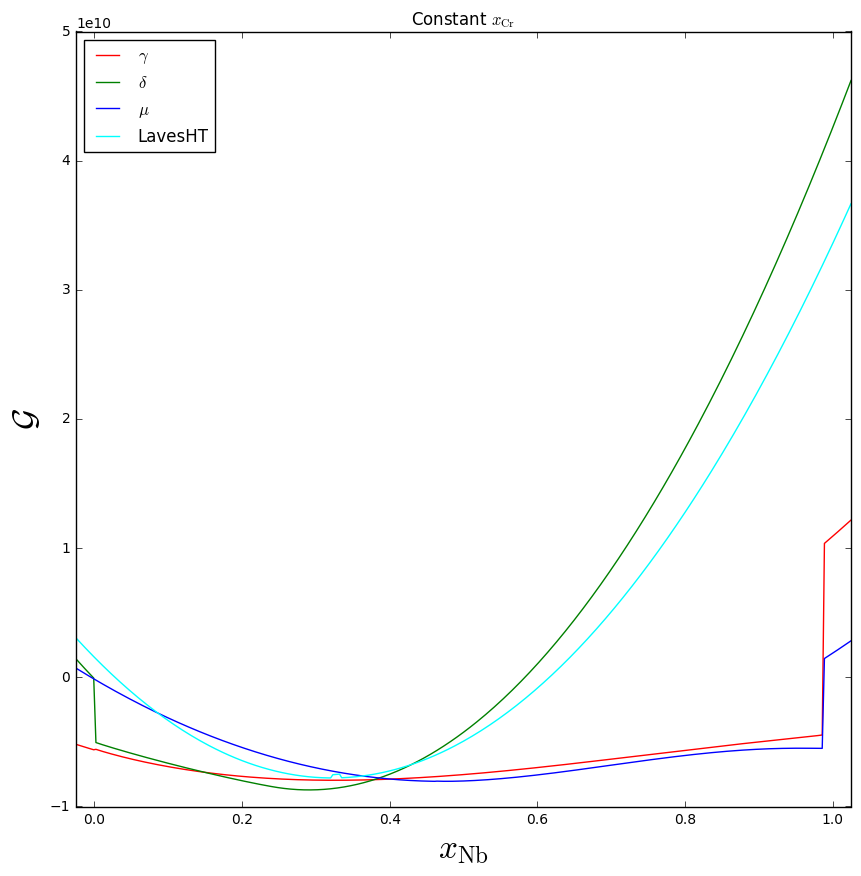

In [3]:
labels = [r'$\gamma$', r'$\delta$', r'$\mu$', 'LavesHT', 'LavesLT', 'BCC', r'$\delta$', r'$\mu$', 'LavesHT', 'LavesLT']
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'green', 'blue', 'cyan', 'magenta']
xlim = [-0.025+epsilon, 1.025]

# plot Gibbs energy curves for fixed x_Cr = 1.25% to check gamma-delta and delta-mu coexistence
if True:   
    xcr = 0.0125
    X = []
    G = [[], [], [], [], [], [], [], [], [], []]

    for xnb in np.linspace(xlim[0], xlim[1], 351):
        X.append(xnb)
        G[0].append(GG(xcr, xnb))
        G[1].append(GD(xcr, xnb))
        G[2].append(GU(xcr, xnb))
        G[3].append(GL(xcr, xnb))

    plt.figure(figsize=(10, 10))
    plt.title("Constant $x_\mathrm{Cr}$")
    plt.xlabel(r'$x_\mathrm{Nb}$', fontsize=24)
    plt.ylabel(r'$\mathcal{G}$', fontsize=24)
    plt.xlim(xlim)
    for i in range(4):
        plt.plot(X, G[i], color=colors[i], label=labels[i])
    plt.legend(loc='best')

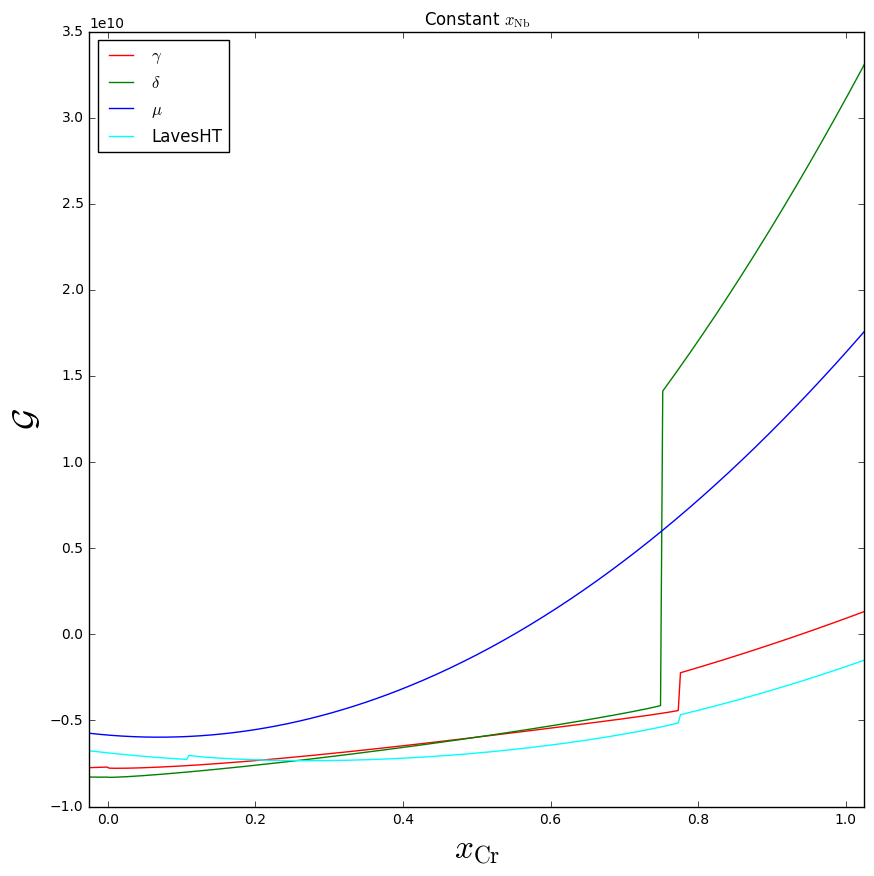

In [4]:
# plot Gibbs energy curves for fixed x_Nb = 22.5% to check delta-Laves coexistence
if True:
    xnb = 0.225
    X = []
    G = [[], [], [], [], [], [], [], [], [], []]

    for xcr in np.linspace(xlim[0], xlim[1], 351):
        xni = 1-xcr-xnb
        X.append(xcr)
        G[0].append(GG(xcr, xnb))
        G[1].append(GD(xcr, xnb))
        G[2].append(GU(xcr, xnb))
        G[3].append(GL(xcr, xnb))

    plt.figure(figsize=(10, 10))
    plt.title("Constant $x_\mathrm{Nb}$")
    plt.xlabel(r'$x_\mathrm{Cr}$', fontsize=24)
    plt.ylabel(r'$\mathcal{G}$', fontsize=24)
    plt.xlim(xlim)
    for i in range(4):
        plt.plot(X, G[i], color=colors[i], label=labels[i])
    plt.legend(loc='best')

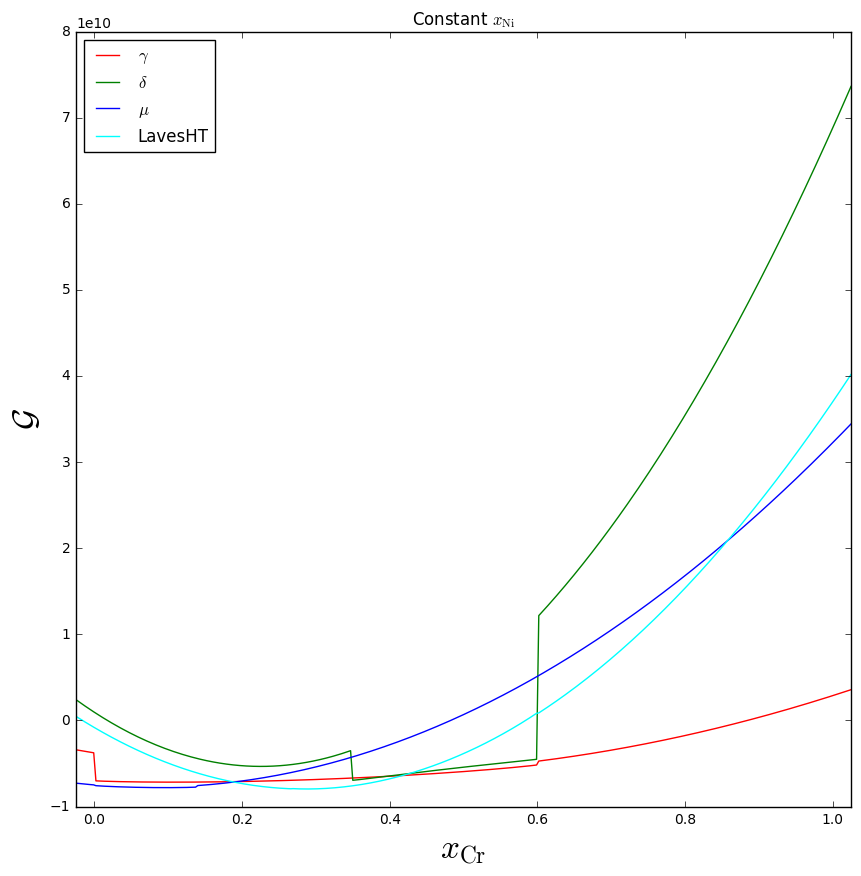

In [5]:
# plot Gibbs energy curves for fixed x_Ni = 40% to check mu-Laves coexistence
if True:
    xni = 0.40
    X = []
    G = [[], [], [], [], [], [], [], [], [], []]

    for xcr in np.linspace(xlim[0], xlim[1], 351):
        xnb = 1-xcr-xni
        X.append(xcr)
        G[0].append(GG(xcr, xnb))
        G[1].append(GD(xcr, xnb))
        G[2].append(GU(xcr, xnb))
        G[3].append(GL(xcr, xnb))

    plt.figure(figsize=(10, 10))
    plt.title("Constant $x_\mathrm{Ni}$")
    plt.xlabel(r'$x_\mathrm{Cr}$', fontsize=24)
    plt.ylabel(r'$\mathcal{G}$', fontsize=24)
    plt.xlim(xlim)
    for i in range(4):
        plt.plot(X, G[i], color=colors[i], label=labels[i])
    plt.legend(loc='best')

# Generate a phase diagram
Using scipy.spatial.ConvexHull, an interface to qhull. This method cannot provide phase fractions, chemical potentials, etc., but will quickly produce the correct diagram from the given Gibbs energies.

In [6]:
labels = [r'$\gamma$', r'$\delta$', r'$\mu$', 'LavesHT', 'LavesLT', 'BCC']
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow']

# Tick marks along simplex edges
Xtick = []
Ytick = []
for i in range(20):
    # Cr-Ni edge
    xcr = 0.05*i
    xni = 1.0 - xcr
    Xtick.append(xcr/2 - 0.002)
    Ytick.append(rt3by2*xcr)
    # Cr-Nb edge
    xcr = 0.05*i
    xnb = 1.0 - xcr
    Xtick.append(xnb + xcr/2 + 0.002)
    Ytick.append(rt3by2*xcr)

In [7]:
def computeKernelExclusive(n):
    a = n / density # index along x-axis
    b = n % density # index along y-axis

    xnb = epsilon + 1.0*a / (density-1)
    xcr = epsilon + 1.0*b / (density-1)
    xni = 1.0 - xcr - xnb

    result = [0]*7
    
    if xni>0:
        result[0] = xcr
        result[1] = xnb
        result[2] = xni
        result[3] = GG(xcr, xnb)
        result[4] = GD(xcr, xnb)
        result[5] = GU(xcr, xnb)
        result[6] = GL(xcr, xnb)
    
    return result

In [8]:
density = 251
allCr = []
allNb = []
allG = []
allID = []
points = []
phases = []

if __name__ == '__main__':
    starttime = time.time() # not exact, but multiprocessing makes time.clock() read from different cores

    bar = FloatProgress(min=0,max=density**2)
    display(bar)

    pool = Pool(12)

    i = 0
    for result in pool.imap(computeKernelExclusive, range(density**2)):
        xcr, xnb, xni, fg, fd, fu, fh = result
        f = (fg, fd, fu, fh)

        # Accumulate (x, y, G) points for each phase
        if (fd**2 + fu**2 + fh**2) > epsilon:
            for n in range(len(f)):
                allNb.append(simX(xnb, xcr))
                allCr.append(simY(xcr))
                allG.append(f[n])
                allID.append(n)
        i += 1
        bar.value = i

    pool.close()
    pool.join()
    
    points = np.array([allNb, allCr, allG]).T
    
    hull = ConvexHull(points)
    
    runtime = time.time() - starttime
    print "%ih:%im:%is elapsed" % (int(runtime/3600), int(runtime/60)%60, int(runtime)%60)

0h:0m:55s elapsed


In [9]:
# Prepare arrays for plotting
X = [[],[],[],[], [], []]
Y = [[],[],[],[], [], []]
tielines = []

for simplex in hull.simplices:
    for i in simplex:
        X[allID[i]].append(allNb[i])
        Y[allID[i]].append(allCr[i])
        for j in simplex:
            if allID[i] != allID[j]:
                tielines.append([[allNb[i], allNb[j]],
                                 [allCr[i], allCr[j]]])

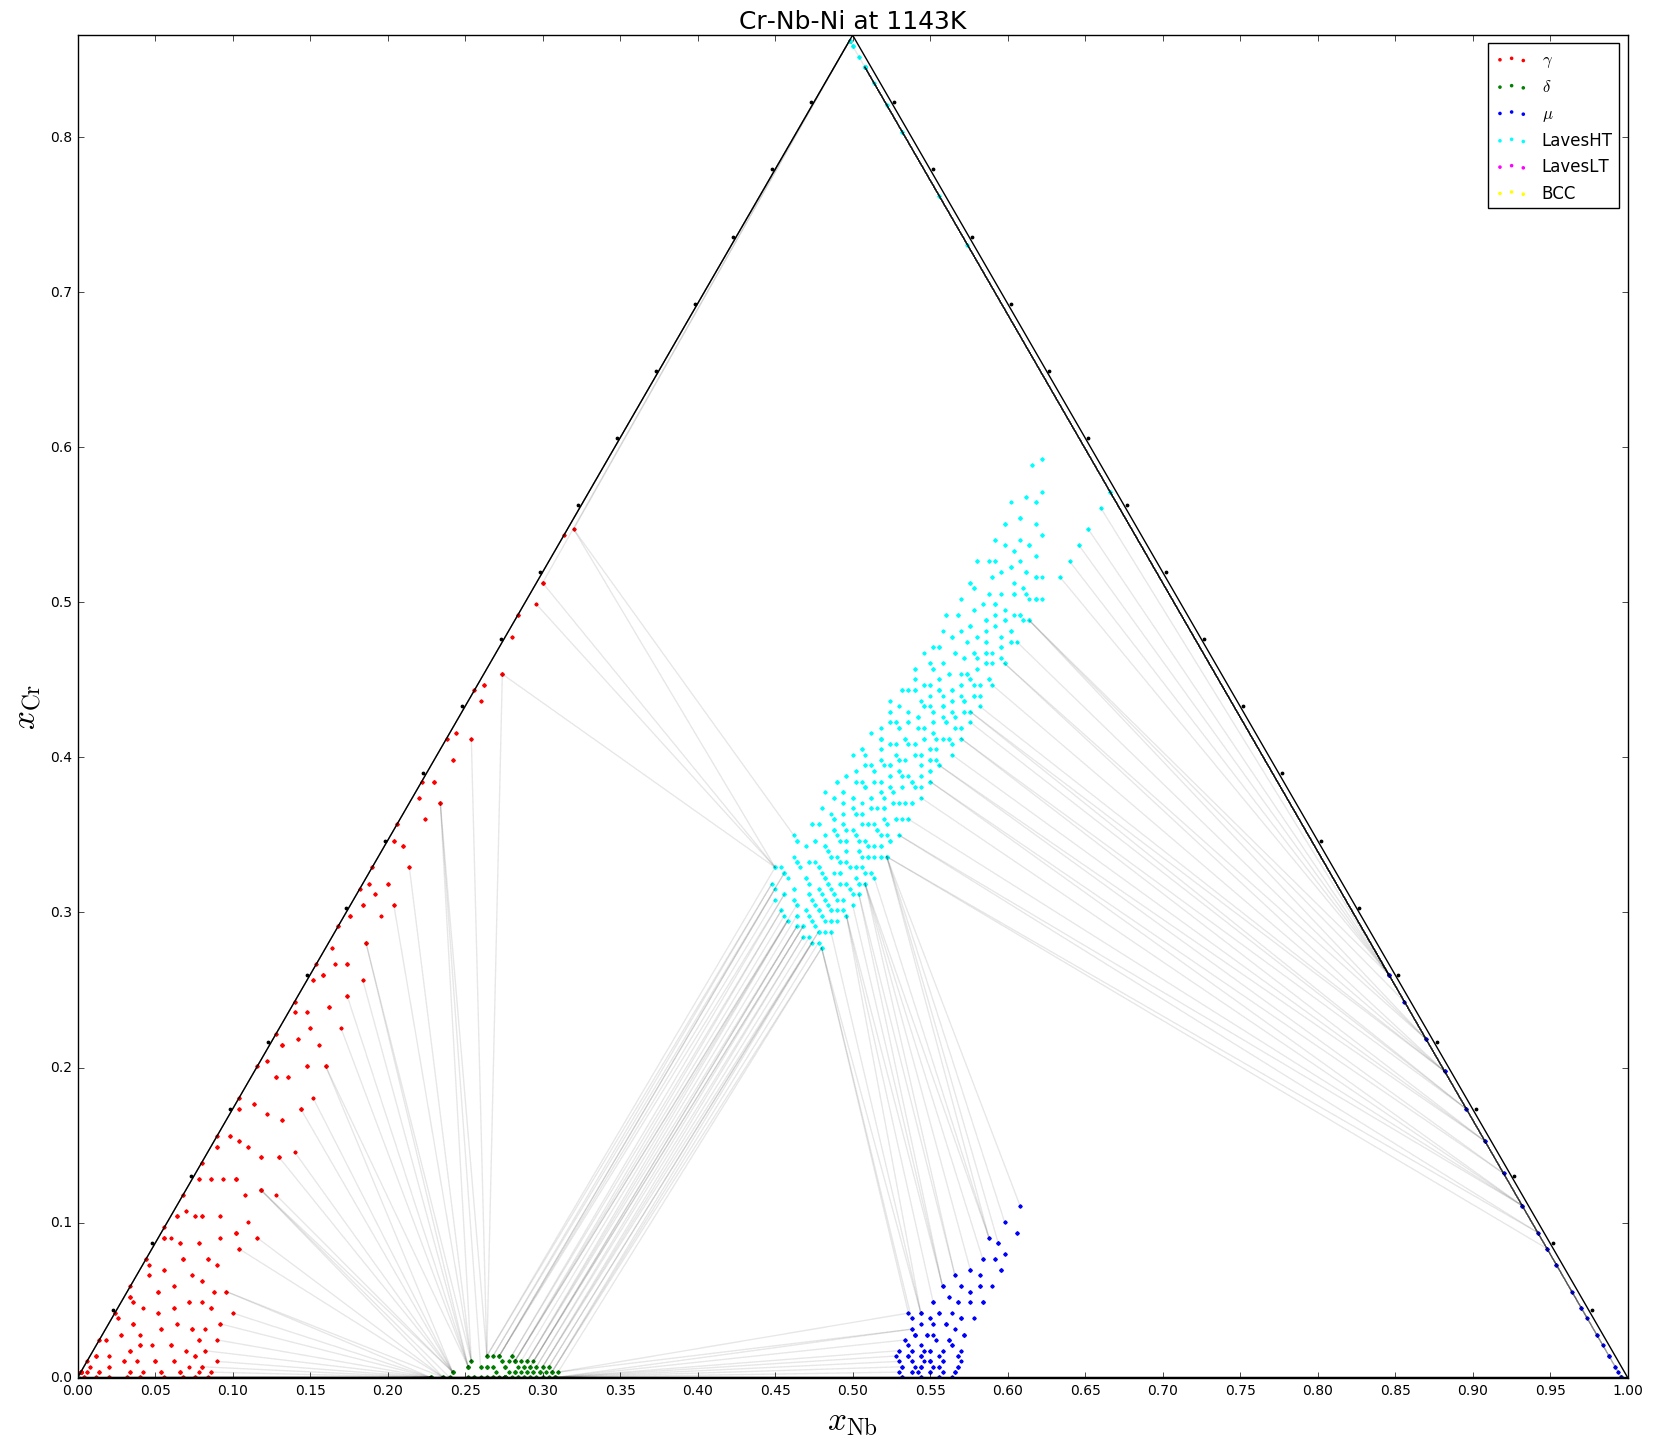

In [10]:
# Plot phase diagram
pltsize = 20
plt.figure(figsize=(pltsize, rt3by2*pltsize))
plt.title("Cr-Nb-Ni at %.0fK"%temp, fontsize=18)
plt.xlim([0,1])
plt.ylim([0,rt3by2])
plt.xlabel(r'$x_\mathrm{Nb}$', fontsize=24)
plt.ylabel(r'$x_\mathrm{Cr}$', fontsize=24)
plt.plot(XS, YS, '-k')
n = 0
for tie in tielines:
    plt.plot(tie[0], tie[1], '-k', alpha=0.025)
for i in range(len(labels)):
    plt.scatter(X[i], Y[i], color=colors[i], s=2.5, label=labels[i])
plt.xticks(np.linspace(0, 1, 21))
plt.scatter(Xtick, Ytick, color='black', s=3)
plt.legend(loc='best')
plt.show()

## Interfacial Energy
This is a naïve attempt to determine an appropriate interfacial energy for $\mu$-phase by finding the balancing point of metastable equilibrium between $\gamma$ and $\mu$.

In [11]:
sigma_del = 1.01 # J/m^2
sigma_mu = sigma_del #/ 10 # J/m^2
sigma_lav = sigma_del #/ 10 # J/m^2
sigma_gprime = sigma_del / 20 # J / m^2: absolute minimum interfacial energy!
#if sigma_gprime > sigma_mu or sigma_gprime > sigma_lav:
#    # complain bitterly and at length about breaking physics    

rmax = 1.0e-8  # m
rmin = 1.0e-16 # m
Vm = 1.0e-5 # m**3/mol

radius = 7.0e-9

In [12]:
def computeKernelInterfacial(n):
    a = n / density # index along x-axis
    b = n % density # index along y-axis

    xnb = epsilon + 1.0*a / (density-1)
    xcr = epsilon + 1.0*b / (density-1)
    xni = 1.0 - xcr - xnb

    result = [0]*7
    
    if xni>0:
        result[0] = xcr
        result[1] = xnb
        result[2] = xni
        result[3] = TG(xcr,xnb)
        result[4] = TD(xcr,xnb) + 2.0 * Vm * sigma_del / radius
        result[5] = TU(xcr,xnb) + 2.0 * Vm * sigma_mu  / radius
        result[6] = TL(xcr,xnb) + 2.0 * Vm * sigma_lav / radius

    return result

In [13]:
density = 201
allCr = []
allNb = []
allG = []
allID = []
points = []
phases = []

if __name__ == '__main__':
    starttime = time.time() # not exact, but multiprocessing makes time.clock() read from different cores

    bar = FloatProgress(min=0, max=density**2)
    display(bar)

    pool = Pool(12)

    i = 0
    for result in pool.imap(computeKernelInterfacial, range(density**2)):
        # Excluding BCC
        xcr, xnb, xni, fg, fd, fu, fh = result
        f = (fg, fd, fu, fh)

        # Accumulate (x, y, G) points for each phase
        if (xcr + xnb + xni) > epsilon:
            for n in range(len(f)):
                allNb.append(simX(xnb, xcr))
                allCr.append(simY(xcr))
                allG.append(f[n])
                allID.append(n)
        i += 1
        bar.value = i

    pool.close()
    pool.join()
    
    points = np.array([allNb, allCr, allG]).T
    
    hull = ConvexHull(points)
    
    runtime = time.time() - starttime
    print "%ih:%im:%is elapsed" % (int(runtime/3600), int(runtime/60)%60, int(runtime)%60)

0h:0m:24s elapsed


In [14]:
# Prepare arrays for plotting
X = [[],[],[],[], [], []]
Y = [[],[],[],[], [], []]
tielines = []

for simplex in hull.simplices:
    for i in simplex:
        X[allID[i]].append(allNb[i])
        Y[allID[i]].append(allCr[i])
        for j in simplex:
            if allID[i] != allID[j]:
                tielines.append([[allNb[i], allNb[j]],
                                 [allCr[i], allCr[j]]])

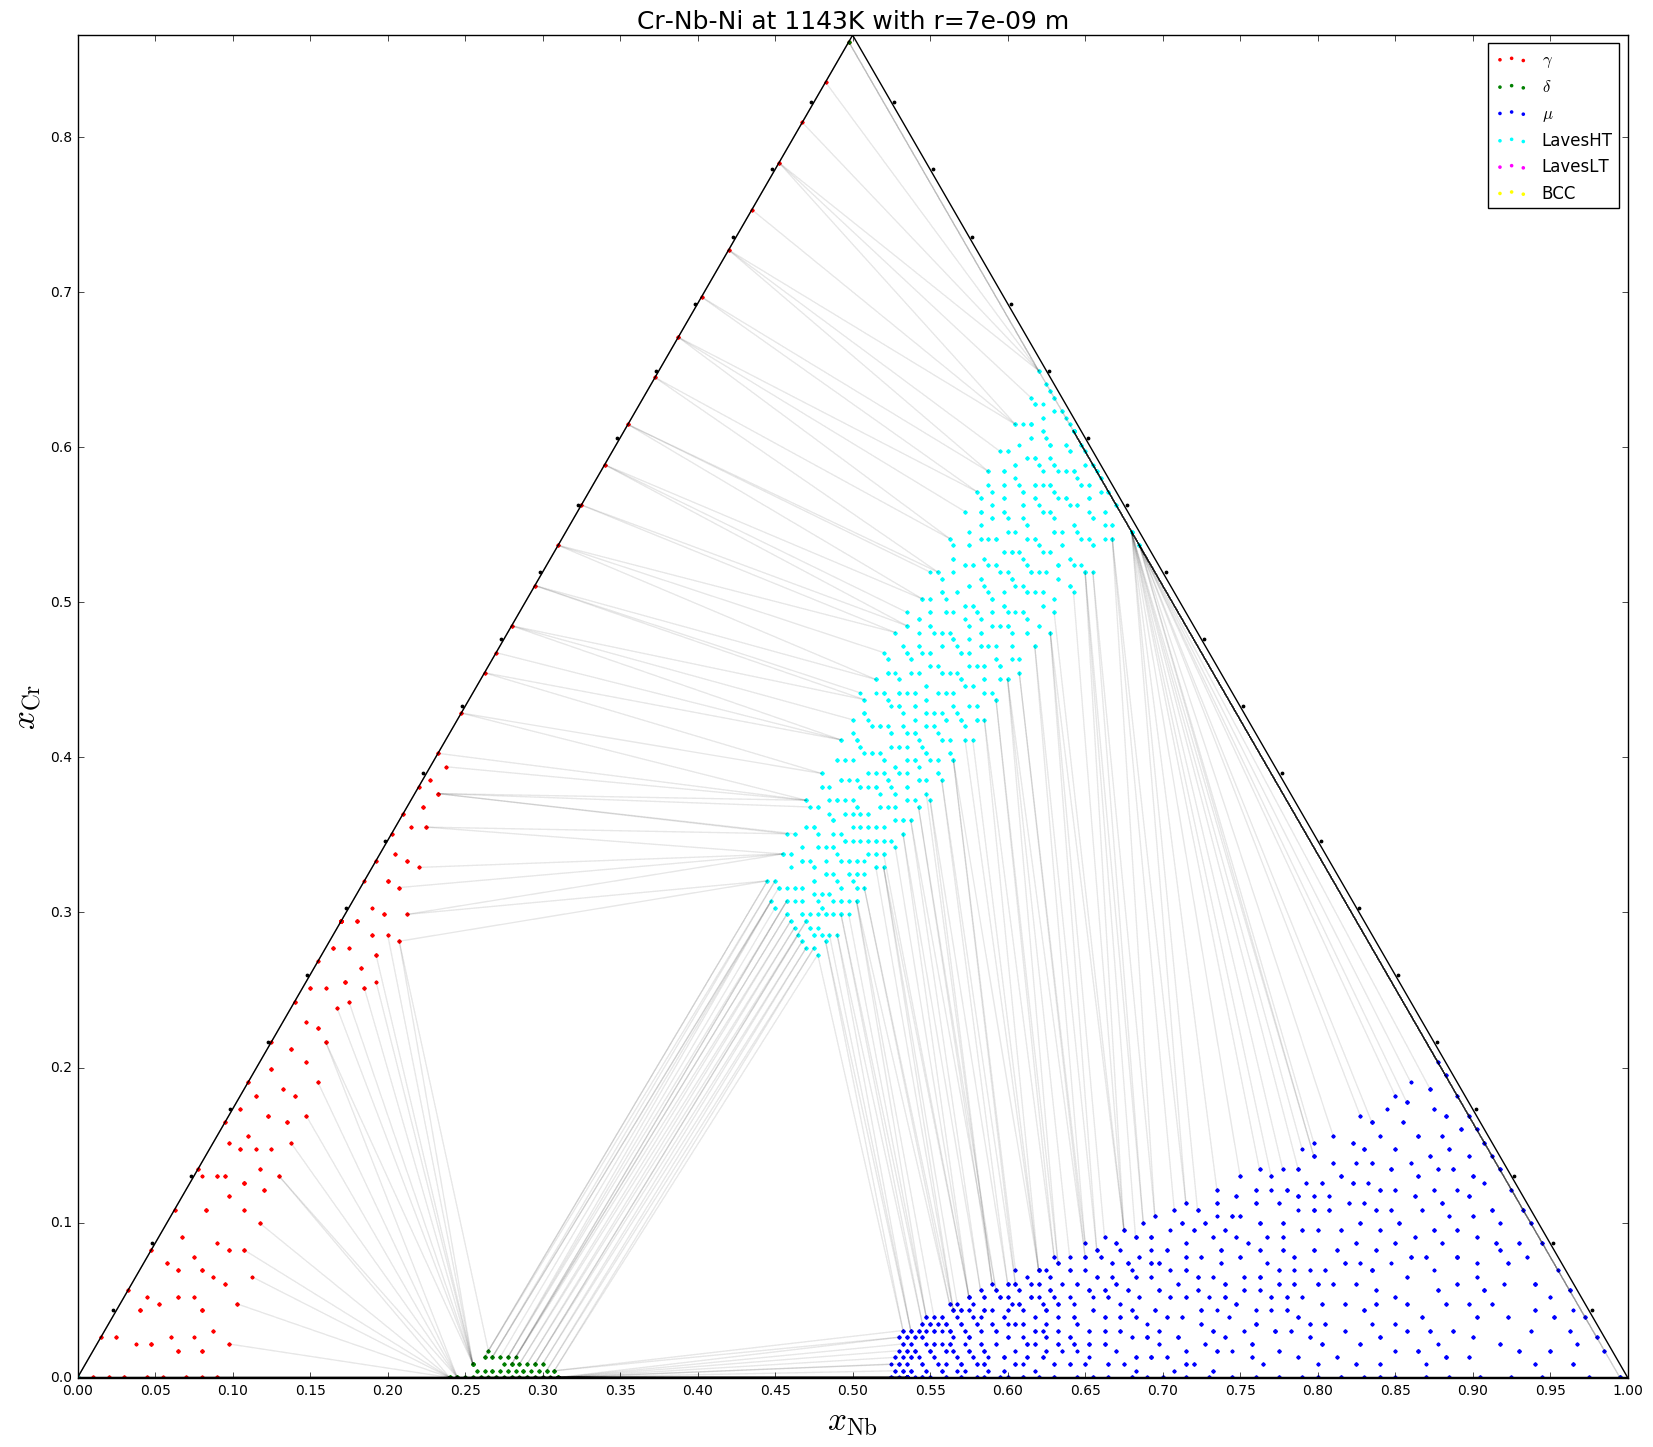

In [15]:
# Plot phase diagram
pltsize = 20
plt.figure(figsize=(pltsize, rt3by2*pltsize))
plt.title("Cr-Nb-Ni at %.0fK with r=%.0e m"%(temp, radius), fontsize=18)
plt.xlim([0,1])
plt.ylim([0,rt3by2])
plt.xlabel(r'$x_\mathrm{Nb}$', fontsize=24)
plt.ylabel(r'$x_\mathrm{Cr}$', fontsize=24)
plt.plot(XS, YS, '-k')
for tie in tielines:
    plt.plot(tie[0], tie[1], '-k', alpha=0.025)
for i in range(len(labels)):
    plt.scatter(X[i], Y[i], color=colors[i], s=2.5, label=labels[i])
plt.xticks(np.linspace(0, 1, 21))
plt.scatter(Xtick, Ytick, color='black', s=3)
plt.legend(loc='best')
plt.show()

## Scan over precipitate sizes
For the initial condition, need to know how big (or small) to make each precipitate.

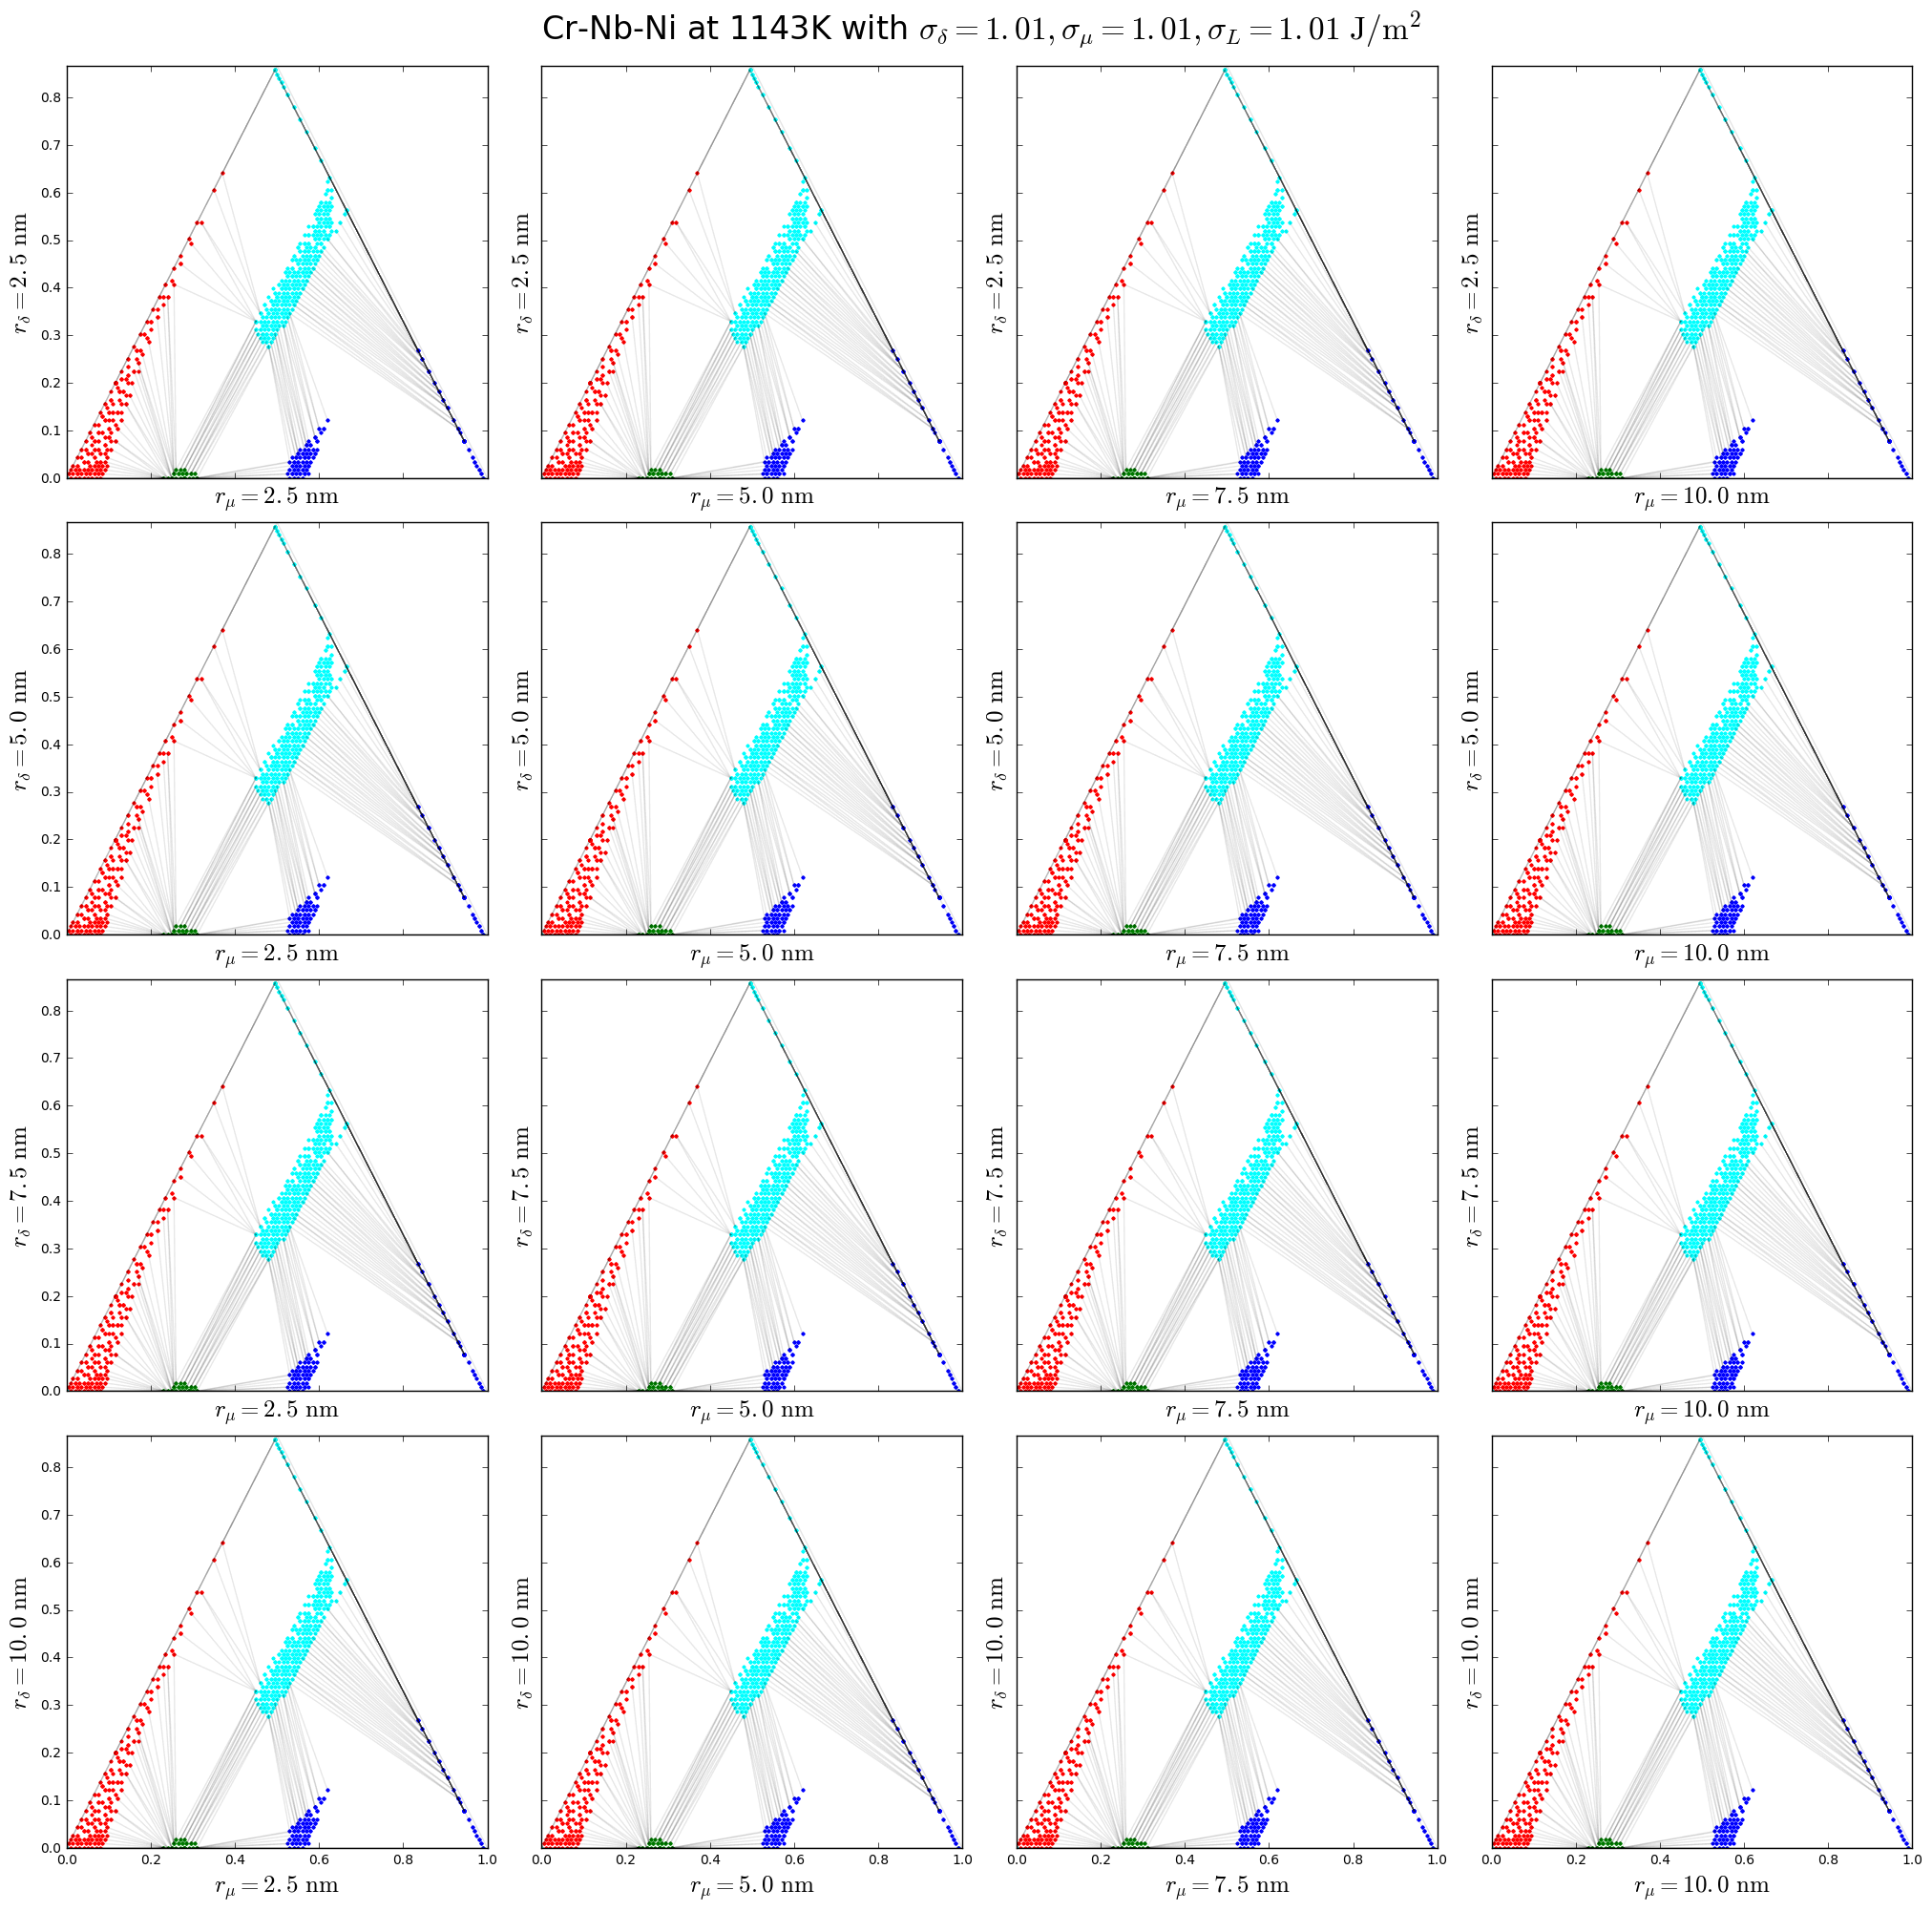

In [16]:
density = 101
lattice = 4
r0 = 2.5e-9
sigma = 1.01 # J/m^2
sA = sigma
sB = sigma
sC = sigma

def computeKernelLattice(n):
    a = n / density # index along x-axis
    b = n % density # index along y-axis

    xnb = epsilon + 1.0*a / (density-1)
    xcr = epsilon + 1.0*b / (density-1)
    xni = 1.0 - xcr - xnb

    result = [0]*7
    
    if xni>0:
        result[0] = xcr
        result[1] = xnb
        result[2] = xni
        result[3] = GG(xcr,xnb)
        result[4] = GD(xcr,xnb) + 2.0 * Vm * sA / rA
        result[5] = GU(xcr,xnb) + 2.0 * Vm * sB / rB
        result[6] = GL(xcr,xnb) + 2.0 * Vm * sC / rC

    return result

fig, axs = plt.subplots(lattice, lattice, sharex=True, sharey=True, figsize=(pltsize, pltsize))
fig.suptitle(r"Cr-Nb-Ni at %.0fK with $\sigma_\delta=%.2f, \sigma_\mu=%.2f, \sigma_L=%.2f\ \mathrm{J/m^2}$"%(temp,sA,sB,sC), fontsize=24)
fig.tight_layout(pad=1.0, w_pad=2.5, h_pad=2.5)
fig.subplots_adjust(top=0.95)

bar = FloatProgress(min=0, max=lattice**2)
display(bar)

for p in range(lattice):
    for q in range(lattice):
        rA = r0 * (p+1) # m
        rB = r0 * (q+1) # m
        rC = rB         # m
        
        allCr = []
        allNb = []
        allG = []
        allID = []
        points = []
        phases = []

        pool = Pool(12)
        for result in pool.imap(computeKernelLattice, range(density**2)):
            xcr, xnb, xni, fg, fd, fu, fh = result
            f = (fg, fd, fu, fh)

            # Accumulate (x, y, G) points for each phase
            if (xcr + xnb + xni) > epsilon:
                for n in range(len(f)):
                    allNb.append(simX(xnb, xcr))
                    allCr.append(simY(xcr))
                    allG.append(f[n])
                    allID.append(n)
        pool.close()
        pool.join()

        points = np.array([allNb, allCr, allG]).T

        hull = ConvexHull(points)

        X = [[],[],[],[], [], []]
        Y = [[],[],[],[], [], []]
        tielines = []

        for simplex in hull.simplices:
            for i in simplex:
                X[allID[i]].append(allNb[i])
                Y[allID[i]].append(allCr[i])
                for j in simplex:
                    if allID[i] != allID[j]:
                        tielines.append([[allNb[i], allNb[j]],
                                         [allCr[i], allCr[j]]])
        
        axs[p,q].set_xlim([0,1])
        axs[p,q].set_ylim([0,rt3by2])
        axs[p,q].set_xlabel(r'$r_\mu=%.1f\ \mathrm{nm}$'%(2.5*(q+1)), fontsize=18)
        axs[p,q].set_ylabel(r'$r_\delta=%.1f\ \mathrm{nm}$'%(2.5*(p+1)), fontsize=18)
        axs[p,q].plot(XS, YS, '-k', alpha=0.1)
        for tie in tielines:
            axs[p,q].plot(tie[0], tie[1], '-k', alpha=0.025)
        for i in range(len(labels)):
            axs[p,q].scatter(X[i], Y[i], color=colors[i], s=2.5)
        bar.value = (p*lattice) + q + 1

plt.show()